In [1]:
from multiprocessing import freeze_support
import pandas as pd
import string
import nltk
import re
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from gensim.models import Phrases, CoherenceModel
from nltk.tokenize import word_tokenize
from gensim.test.utils import datapath
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.cm as cm
from sklearn.manifold import TSNE

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
nltk.download('wordnet')
nltk.download('punkt')

wordnet_lemmatizer = WordNetLemmatizer()
wpt = nltk.WordPunctTokenizer()
lemmatizer = nltk.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zesha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zesha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zesha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Point to directories 

jobs = pd.read_csv(r"C://Users//zesha//Downloads//all_jobs.csv")
resumes = pd.read_csv(r"C://Users//zesha//Downloads//all_resumes.csv")

In [3]:
# How many jobs and resumes

print("Number of jobs: " + str(jobs.shape[0]))
print("Number of resumes: " + str(resumes.shape[0]))

# We are only running our model based on the job description

jobs_desc = jobs['job_description'].copy()

Number of jobs: 20000
Number of resumes: 29783


In [4]:
### PREPROCESSING

def remove_punc(corpus):
    punc_free = "".join([i for i in corpus if i not in string.punctuation])
    return punc_free

def tokenization(corpus):
    tokens = wpt.tokenize(corpus)
    return tokens

def remove_stopwords(corpus):
    output = [i for i in corpus if i not in stopwords]
    return output

def lemmization(corpus):
    lemm = [wordnet_lemmatizer.lemmatize(word) for word in corpus]
    return lemm

def cleanResume(corpus):
    corpus = re.sub('httpS+s*', ' ', corpus)  # remove URLs
    corpus = re.sub('RT|cc', ' ', corpus)  # remove RT and cc
    corpus = re.sub('#S+', '', corpus)  # remove hashtags
    corpus = re.sub('@S+', '  ', corpus)  # remove mentions
    corpus = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', corpus)  # remove punctuations
    return corpus

def preprocessing(resumes):
    resumes['cleaned'] = resumes.apply(lambda x: cleanResume(x))
    print("Cleaned corpus")
    resumes['cleaned'] = resumes['cleaned'].apply(lambda x:remove_punc(x))
    print("Removed punctuation")
    resumes['cleaned'] = resumes['cleaned'].apply(lambda x:x.lower())
    print("Lowercase")
    resumes['cleaned'] = resumes['cleaned'].apply(lambda x:tokenization(x))
    print("Tokenized corpus")
    resumes['cleaned'] = resumes['cleaned'].apply(lambda x:remove_stopwords(x))
    print("Removed Stopwords")
    resumes['cleaned'] = resumes['cleaned'].apply(lambda x:lemmization(x))
    print("Lemmatized corpus")
    resumes.head()
    return resumes

In [5]:
corpus = preprocessing(jobs_desc)
corpus = jobs_desc['cleaned'].tolist()    

Cleaned corpus
Removed punctuation
Lowercase
Tokenized corpus
Removed Stopwords
Lemmatized corpus


In [6]:
corpus_list = []
for i in range (len(corpus)):
    temp = []
    for word in (corpus[i]):
        temp.append(word)
    temp = " ".join(temp)
    corpus_list.append(temp)

In [7]:
#Tokenise the corpus
tokenized_corp = [word_tokenize(i) for i in corpus_list]

# Create Dictionary
id2word = corpora.Dictionary(tokenized_corp)

#Remove words that don't feature 20 times and those that feature in over 50% of documents
id2word.filter_extremes(no_below=20, no_above=0.5)

texts = tokenized_corp

# Term Document Frequency
corpus_final = [id2word.doc2bow(text) for text in texts]

In [8]:
def find_optimal_clusters(dataframe1, max_k):
    iters = range(1, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=100).fit(dataframe1).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

In [9]:
dataframe = pd.DataFrame(corpus_list)
dataframe.columns = ["Description"]

dataframe.head()

,Description
0,chosen sr software developer part larger engin...
1,position c lead software developer location mi...
2,senior software developer hoboken nj start 9 1...
3,client multinational publishing education comp...
4,position c lead software developer location ph...


In [10]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 2000,
    stop_words = 'english'
)
tfidf.fit(dataframe.Description)
text = tfidf.transform(dataframe.Description)

Fit 1 clusters
Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


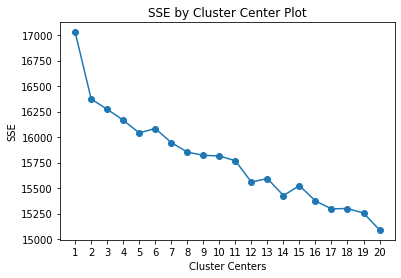

In [11]:
find_optimal_clusters(text, 20)

In [12]:
clusters = MiniBatchKMeans(n_clusters=12, init_size= 200, batch_size=400, random_state=0).fit_predict(text)

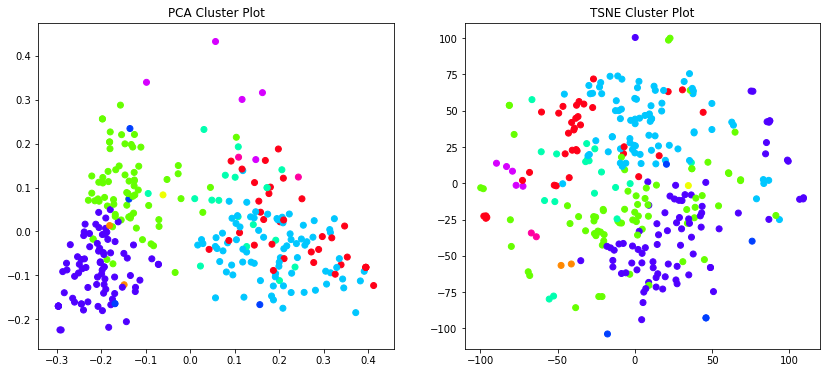

In [13]:
def plot_tsne_pca(dataframe1, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(dataframe1.shape[0]), size=10000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(dataframe1[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(dataframe1[max_items,:].todense()))    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [14]:
# Actual LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus_final,
                                       id2word=id2word,
                                       num_topics=12, 
                                       random_state=123,
                                       chunksize=128,
                                       passes=45, #number of passes was investigated. At 500 the coherence score will remain relatively similar
                                       #with any further increase. As the document is quite small this number of passes makes sense.
                                       per_word_topics=True)


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')

In [15]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"developer" + 0.015*"web" + 0.011*"test" + 0.011*"agile" + '
  '0.010*"testing" + 0.010*"code" + 0.009*"product" + 0.009*"framework" + '
  '0.008*"cloud" + 0.008*"javascript"'),
 (1,
  '0.011*"position" + 0.010*"u" + 0.010*"program" + 0.009*"client" + '
  '0.008*"company" + 0.008*"financial" + 0.007*"’" + 0.007*"career" + '
  '0.007*"time" + 0.006*"candidate"'),
 (2,
  '0.012*"management" + 0.009*"process" + 0.007*"information" + 0.006*"duty" + '
  '0.006*"customer" + 0.006*"position" + 0.006*"provide" + 0.005*"standard" + '
  '0.005*"may" + 0.005*"level"'),
 (3,
  '0.033*"net" + 0.019*"microsoft" + 0.015*"server" + 0.014*"web" + '
  '0.012*"developer" + 0.011*"asp" + 0.011*"c" + 0.008*"insurance" + '
  '0.007*"visual" + 0.007*"benefit"'),
 (4,
  '0.015*"learning" + 0.014*"scientist" + 0.014*"please" + 0.012*"apply" + '
  '0.012*"today" + 0.011*"code" + 0.011*"position" + 0.011*"location" + '
  '0.009*"posted" + 0.009*"industry"'),
 (5,
  '0.018*"security" + 0.014*"cleara

ValueError: too many values to unpack (expected 2)